##Clone resources and import packages

In [0]:
# If you have not already cloned the following repository, do so now
!git clone https://github.com/ZanePeycke/dvu.git

fatal: destination path 'dvu-scene-recognition' already exists and is not an empty directory.


In [0]:
import os
import numpy as np
import cv2
from PIL import Image
from cv2 import resize
import requests
from io import BytesIO
import matplotlib.pyplot as plt

%cd /content/dvu-scene-recognition
from vgg16_places_365 import VGG16_Places365


/content/dvu-scene-recognition


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Load Model

In [0]:
model = VGG16_Places365(weights='places')

## Functions for classification

In [0]:
def load_categories():
  # load the class label
  file_name = 'categories_places365.txt'
  if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
  classes = list()
  with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
  classes = tuple(classes)
  return classes

In [0]:
def scene_recognition(image, predictions_to_return, classes):
  image = np.array(image, dtype=np.uint8)
  image = resize(image, (224, 224))
  if len(image.shape) > 2 and image.shape[2] == 4:
    #convert the image from RGBA2RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
  image = np.expand_dims(image, 0)

  # Predict and generate results
  predictions_to_return = predictions_to_return
  preds = model.predict(image)[0]
  top_preds = np.argsort(preds)[::-1][0:predictions_to_return]

  categories = []
  for i in range(0, predictions_to_return):
    categories.append(classes[top_preds[i]])
  
  return categories

In [0]:
def pull_frame(video_path, timestamp):
  vidcap = cv2.VideoCapture(video_path)
  vidcap.set(cv2.CAP_PROP_POS_MSEC, timestamp)
  success, image = vidcap.read()
  return image

## Make Predictions

In [0]:
classes = load_categories()


image = pull_frame('/content/drive/My Drive/DVU_Challenge/Movies/SuperHero.mp4', 130000)
categories = scene_recognition(image, 5, classes)
if len(categories) == 1:
  print(f'The most likely scene category is: {categories}')
else:
  print(f'The most likely scene categories are: {categories}')

The Most likely scene categories are: ['berth', 'hotel_room', 'bedroom', 'childs_room', 'bedchamber']


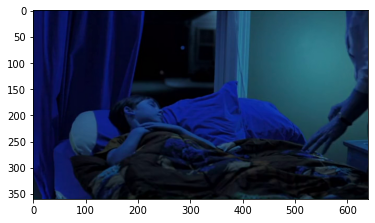

In [0]:
# For reference we can plot the image
plt.imshow(image)
plt.show()